#Trading META With GARCH Volatilty Predications








In my studies, I came across a unique way to trade securities: using statistical predictions as trading signals. The particular model that caught my interest is the GARCH model, which outperforms other autoregressive/moving average models in predicting volatility. In this setup, I will demonstrate a trading strategy that relies on fluctuations in S&P 500 return volatility. When the predicted value exceeds the historical value, we will initiate a buy, otherwise, we will sell. The model I have trained utilizes two lags. Initially, I aim to showcase the model's usage before delving into any further refinements.

#Computing Log Returns and Volatility

In [ ]:
import numpy as np
import pandas as pd
from arch import arch_model
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
import matplotlib.dates as mdates
%matplotlib inline
plt.style.use('seaborn-darkgrid')
import warnings
warnings.filterwarnings('ignore')

In [ ]:
start = dt.datetime(2018, 1, 1).date()
end = dt.datetime.now()

In [ ]:
SPdata = yf.download("^GSPC", end=end)
SPdata.rename(columns={'Adj Close': 'S&P 500'}, inplace=True)
SPdata.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)

Metatrade = yf.download("META", start=start, end=end)
Metatrade.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
print(f"{len(SPdata)} number of records downloaded")
print(f"{len(Metatrade)} number of records downloaded")
SPdata

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
23997 number of records downloaded
1391 number of records downloaded


,S&P 500
Date,
1927-12-30,17.660000
1928-01-03,17.760000
1928-01-04,17.719999
1928-01-05,17.549999
1928-01-06,17.660000
...,...
2023-07-07,4398.950195
2023-07-10,4409.529785
2023-07-11,4439.259766


In [ ]:
Metatrade

,Adj Close
Date,
2018-01-02,181.419998
2018-01-03,184.669998
2018-01-04,184.330002
2018-01-05,186.850006
2018-01-08,188.279999
...,...
2023-07-07,290.529999
2023-07-10,294.100006
2023-07-11,298.290009


In [ ]:
SPdata["S&P Log Returns"] = np.log(SPdata['S&P 500'].pct_change() + 1)*100

Metatrade["META Log Returns"] = np.log(Metatrade['Adj Close'].pct_change() + 1)*100

SPdata["S&P Historical Volatility"] = SPdata['S&P Log Returns'].rolling(14).std() * ((252)**0.5)

Metatrade["META Historical Volatility"] = Metatrade['META Log Returns'].rolling(14).std() * ((252)**0.5)

SPdata.round(2)

,S&P 500,S&P Log Returns,S&P Historical Volatility
Date,,,
1927-12-30,17.66,NaN,NaN
1928-01-03,17.76,0.56,NaN
1928-01-04,17.72,-0.23,NaN
1928-01-05,17.55,-0.96,NaN
1928-01-06,17.66,0.62,NaN
...,...,...,...
2023-07-07,4398.95,-0.29,10.13
2023-07-10,4409.53,0.24,10.08
2023-07-11,4439.26,0.67,10.21


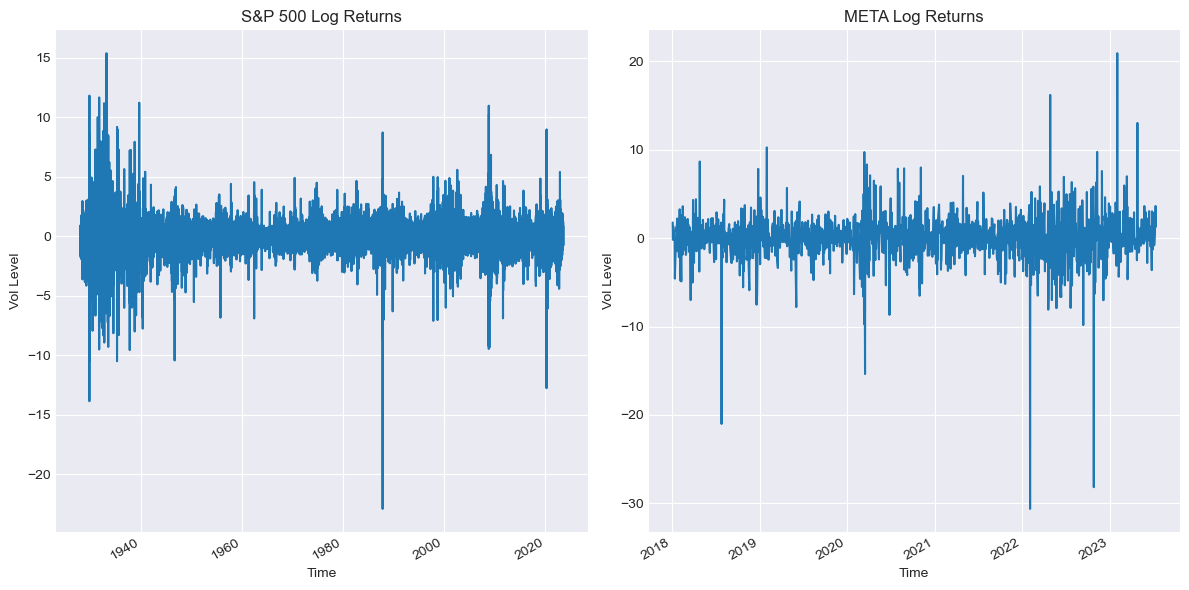

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

SPdata["S&P Log Returns"].plot(ax=axes[0], title="S&P 500 Log Returns", xlabel="Time", ylabel="Vol Level")
Metatrade["META Log Returns"].plot(ax=axes[1], title="META Log Returns", xlabel="Time", ylabel="Vol Level")

plt.tight_layout()
plt.show()

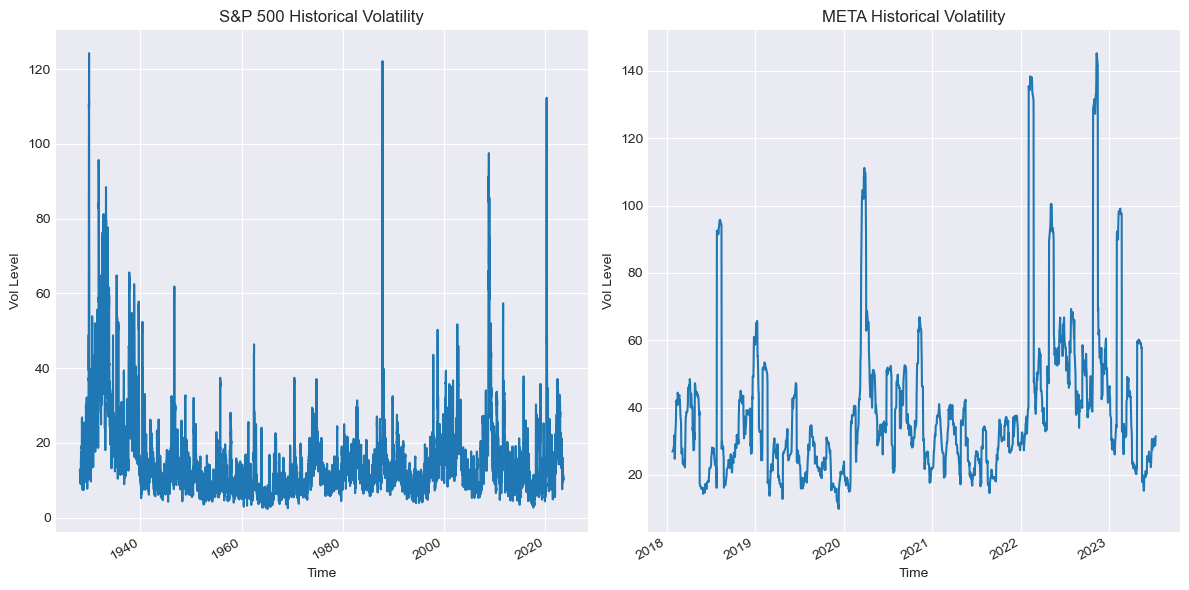

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

SPdata["S&P Historical Volatility"].plot(ax=axes[0], title="S&P 500 Historical Volatility", xlabel="Time", ylabel="Vol Level")
Metatrade["META Historical Volatility"].plot(ax=axes[1], title="META Historical Volatility", xlabel="Time", ylabel="Vol Level")

plt.tight_layout()
plt.show()

#S&P 500 Volatility Prediction

In [ ]:
def predict_volatility(hist_returns_data):
    # Define model
    gm = arch_model(hist_returns_data, vol='GARCH', p=2, q=1, dist='skewt')

    # Fit the model
    gm_fit = gm.fit(disp='off')

    # Make forecast
    forecasted_variance = gm_fit.forecast(horizon=1).variance.values[-1]

    # Forecasted volatility
    forecasted_volatility = forecasted_variance**0.5

    # Calculate and return the annualised forecasted variance
    annualised_volatility = forecasted_volatility * (252**0.5)
    return annualised_volatility

In [ ]:
SPdata['GARCH_predicted_volatility'] = SPdata['S&P Log Returns'].rolling(252).apply(predict_volatility, raw=True)
SPdata['GARCH_predicted_volatility'] = SPdata['GARCH_predicted_volatility'].shift(1)
SPdata.dropna().round(2)

,S&P 500,S&P Log Returns,S&P Historical Volatility,GARCH_predicted_volatility
Date,,,,
1929-01-04,24.85,-0.04,11.57,16.52
1929-01-07,24.25,-2.44,17.69,15.66
1929-01-08,24.17,-0.33,17.62,19.01
1929-01-09,24.54,1.52,17.94,18.16
1929-01-10,24.58,0.16,17.73,18.40
...,...,...,...,...
2023-07-07,4398.95,-0.29,10.13,11.11
2023-07-10,4409.53,0.24,10.08,11.21
2023-07-11,4439.26,0.67,10.21,11.00


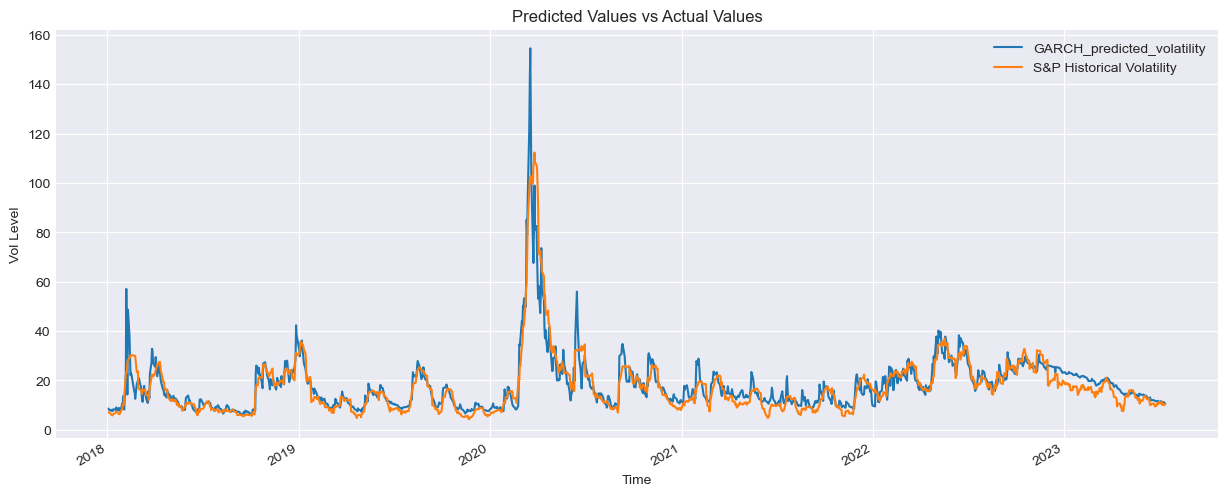

In [ ]:
SPdata[['GARCH_predicted_volatility', 'S&P Historical Volatility']].plot(title='Predicted Values vs Actual Values', xlabel='Time', ylabel='Vol Level', figsize=[15,6])

#Signal Creation and Strategy Analysis

In [ ]:
SPdata['signal'] = np.where(SPdata['GARCH_predicted_volatility'] > SPdata['S&P Historical Volatility'], 1, -1)
SPdata['strategy_returns'] = Metatrade["Adj Close"].pct_change() * SPdata.signal.shift(1)
SPdata.dropna(inplace=True)

In [ ]:
def analyse_strategy(strategy_returns):
    sharpe_ratio = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)
    cumulative_returns = (strategy_returns+1).cumprod()


    running_max = np.maximum.accumulate(cumulative_returns.dropna())
    running_max[running_max < 1] = 1
    drawdown = 100*((cumulative_returns)/running_max - 1)
    max_dd = drawdown.min()

    print('The Sharpe Ratio is %.2f' % sharpe_ratio)
    print('The cumulative return is %.2f' % (
      ((cumulative_returns[-1])-1)*100) + "%")
    print("The maximum drawdown is %.2f" % max_dd + "%")

    labels = strategy_returns.index
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7))

    ax1.plot(cumulative_returns, color='b')
    ax1.set_title('Cumulative Returns', fontsize=14)
    ax1.set_ylabel('Cumulative Returns', fontsize=12)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_xticklabels(labels, rotation=45, ha='right')
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%Y"))
    ax1.xaxis.set_minor_formatter(mdates.DateFormatter("%d-%m-%Y"))


    ax2.plot(drawdown, color='red')

    ax2.fill_between(drawdown.index, drawdown.values, color='red')
    ax2.set_title('Strategy Drawdown', fontsize=14)
    ax2.set_ylabel('Drawdown (%)', fontsize=12)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_xticklabels(labels, rotation=45, ha='right')
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%Y"))
    ax2.xaxis.set_minor_formatter(mdates.DateFormatter("%d-%m-%Y"))

    plt.tight_layout()
    plt.show()


The Sharpe Ratio is 0.58
The cumulative return is 141.28%
The maximum drawdown is -75.75%


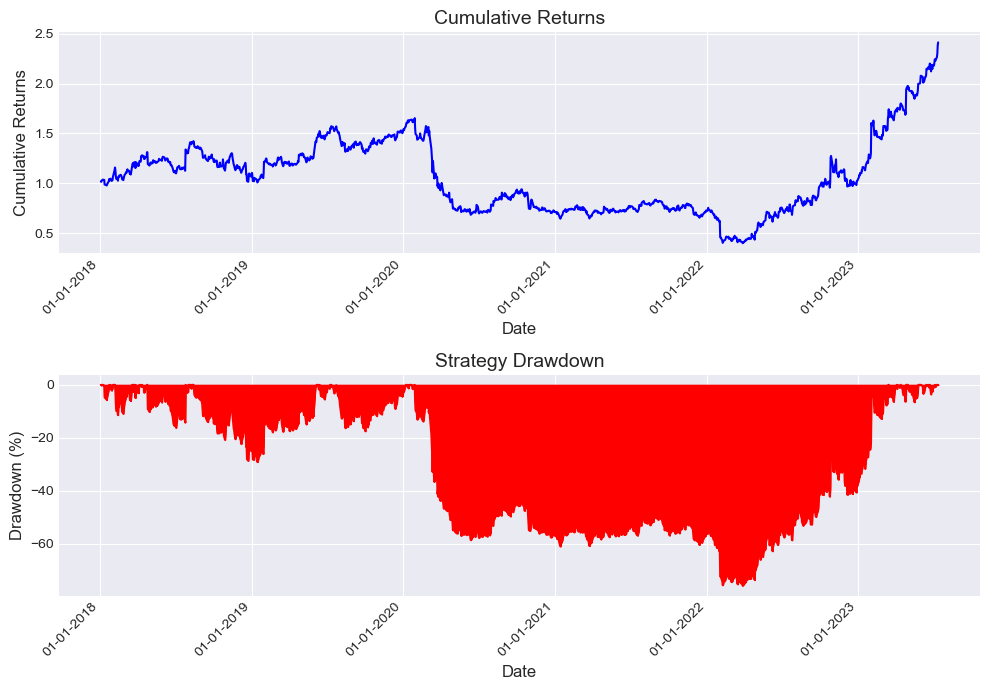

In [ ]:
analyse_strategy(SPdata['strategy_returns'])

Since 2018, trading Meta using this strategy appears to be both feasible and profitable. Based on these findings, I have outlined the following steps I intend to take:

1. Fine-tune the GARCH model further. While some predictions were relatively close to the actual values, I aim to refine the model to achieve even greater accuracy.

2. Explore the application of this trading strategy to another stock within the S&P 500 index. By analyzing the results obtained, I hope to gain insights into how this particular trading strategy can be positioned within a portfolio of algorithmic trading strategies.

By undertaking these actions, I aim to enhance the performance and versatility of the GARCH model while expanding the scope of its application to other stocks within the S&P 500 index.